In [1]:
import torch
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import bliss

import bliss.models.encoder as encoder_lib
from bliss.models.decoder import ImageDecoder
from bliss.models import galaxy_net

from bliss import device, use_cuda
print(device)
print(use_cuda)

data_path = Path('../data/')

cuda
True


In [3]:
torch.manual_seed(2342)
np.random.seed(354)

# Model parameters

In [4]:
# create training dataset
n_bands = 2
slen = 4

tile_slen = 4

In [5]:
# background
background = torch.zeros(n_bands, slen, slen, device=device)
background[:] = 686.0

In [6]:
# psf parameters 
psf_file = data_path.joinpath("fitted_powerlaw_psf_params.npy")
psf_params = torch.from_numpy(np.load(psf_file)).to(device)[0:n_bands]

In [7]:
dec = None
prob_galaxy = 0.

# Define decoder

In [8]:
image_decoder = ImageDecoder(dec,
                        psf_params,
                        background,
                        n_bands=n_bands,
                        slen=slen,
                        tile_slen=tile_slen,
                        prob_galaxy=prob_galaxy,
                        max_sources_per_tile=2,
                        mean_sources_per_tile=0.8,
                        min_sources_per_tile=0,
                        f_min=1e4,
                        f_max=1e6,
                        alpha=0.5,
                        add_noise=False,)

# Sample parameters

In [9]:
max_sources = 2

# one source
n_sources = torch.Tensor([1]).long().to(device)

# set locations
x0 = 1.5
x1 = 2.5
locs = torch.Tensor([[[x0, x1], 
                      [0, 0]]]).to(device) / tile_slen

# galaxy is off
galaxy_bool = torch.zeros(1, max_sources, device = device)
galaxy_params = torch.zeros(1, max_sources, image_decoder.latent_dim, device = device)

# set flux
flx = 1e5
fluxes = torch.ones(1, max_sources, n_bands, device = device) * flx

In [10]:
out = image_decoder._render_ptiles(n_sources, locs, galaxy_bool, galaxy_params, fluxes)

In [11]:
%matplotlib inline

In [12]:
locs[0, 0:n_sources]

tensor([[0.3750, 0.6250]], device='cuda:0')

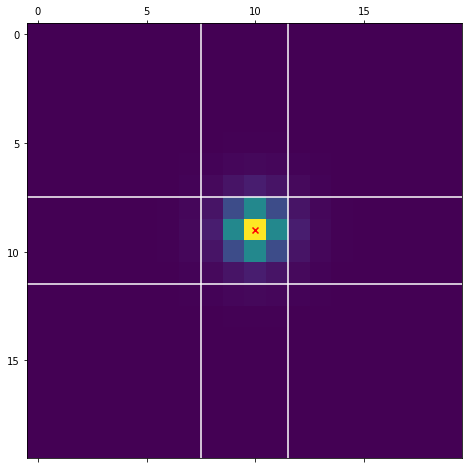

In [13]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))

padding = (image_decoder.ptile_slen - image_decoder.tile_slen) / 2 - 0.5

ax.matshow(out[0, 0].detach().cpu())

# locations 
ax.scatter(locs[0, 0:n_sources, 1].cpu() * image_decoder.tile_slen + padding, 
           locs[0, 0:n_sources, 0].cpu() * image_decoder.tile_slen + padding, 
        color = 'r', marker = 'x')
        
# tile borders
ax.axvline(padding, color = 'white')
ax.axvline(padding + tile_slen, color = 'white')
ax.axhline(padding, color = 'white')
ax.axhline(padding + tile_slen, color = 'white')


In [14]:
out[0, 0].max()

tensor(19548.5430, device='cuda:0', grad_fn=<MaxBackward1>)

In [15]:
image_decoder._get_psf().max() * flx

tensor(19548.5527, device='cuda:0', grad_fn=<MulBackward0>)